In [4]:
import pandas as pd
import json
import string
import pickle
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter, OrderedDict

import torch
from torch.utils.data import Dataset
from torchtext.vocab import vocab
from torchvision.models import resnet18
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score, accuracy_score

In [5]:
def split_fbhm(directory):
    train = []
    with open(f"{directory}train.jsonl") as f:
        for line in f:
            sample = json.loads(line)
            train.append([sample["img"], sample["text"], sample["label"]])

    dev = []
    with open(f"{directory}dev_seen.jsonl") as f:
        for line in f:
            sample = json.loads(line)
            dev.append([sample["img"], sample["text"], sample["label"]])

    return pd.DataFrame(train, columns=["img", "text", "label"]), pd.DataFrame(
        dev, columns=["img", "text", "label"]
    )

In [6]:
def text_clean(text):
    clean = []
    for i, text_ in enumerate(text):
        if type(text_) is str:
            text_ = text_.lower()  # lower case
            text_ = text_.translate(
                str.maketrans("", "", string.punctuation)
            )  # remove punctuation
            text_ = "".join([i for i in text_ if not i.isdigit()])  # remove numbers
            text_ = " ".join(text_.split())  # remove double space
            clean.append(text_)
        else:
            clean.append("notext")
    return clean

In [7]:
class FBHM(Dataset):
    def __init__(
        self,
        directory,
        train,
        vocab_size,
        seq_len,
        transform=None,
    ):
        self.directory = directory
        self.train, self.dev = split_fbhm(self.directory)

        # Create the training text corpus vocabulary
        sentences = text_clean(self.train["text"].tolist())
        words = [w for s in sentences for w in s.split()]
        counts = sorted(Counter(words).items(), key=lambda x: x[1], reverse=True)[
            :vocab_size
        ]
        self.vocabulary = vocab(OrderedDict(counts))
        self.vocabulary.insert_token("<pad>", 0)
        self.vocabulary.insert_token("<unk>", 1)
        self.vocabulary.set_default_index(self.vocabulary["<unk>"])

        # Pick the split's examples to make the dataset
        self.memes = self.train if train else self.dev

        self.seq_len = seq_len
        self.transform = transform

    def __len__(self):
        return len(self.memes)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = self.memes["img"][idx]
        image = Image.open(os.path.join(self.directory, image_name)).convert("RGB")
        text = text_clean([self.memes["text"][idx]])[0]
        text_index = self.vocabulary(text.split())
        label = self.memes["label"][idx]
        sample = {
            "image": image,
            "text": text,
            "text_index": text_index[: self.seq_len]
            if len(text_index) >= self.seq_len
            else text_index
            + [self.vocabulary["<pad>"]] * (self.seq_len - len(text_index)),
            "label": label,
        }
        sample["text_index"] = torch.tensor(sample["text_index"])
        if self.transform:
            sample["image"] = self.transform(sample["image"])
        return sample

In [8]:
class TextOnly(torch.nn.ModuleList):
    def __init__(self, max_words, hidden_dim, lstm_layers, num_classes, device):
        super(TextOnly, self).__init__()
        self.device = device
        self.num_classes = num_classes

        # Hyperparameters
        self.input_size = max_words
        self.hidden_dim = hidden_dim
        self.LSTM_layers = lstm_layers

        self.dropout = torch.nn.Dropout(0.5)
        self.embedding = torch.nn.Embedding(
            self.input_size, self.hidden_dim, padding_idx=0
        )
        self.lstm = torch.nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.LSTM_layers,
            batch_first=True,
        )
        self.fc1 = torch.nn.Linear(
            in_features=self.hidden_dim, out_features=self.hidden_dim * 2
        )
        self.fc2 = torch.nn.Linear(self.hidden_dim * 2, num_classes)

    def forward(self, x):
        # Hidden and cell state definion
        h = torch.zeros(
            (self.LSTM_layers, x["text_index"].to(self.device).size(0), self.hidden_dim)
        ).to(self.device)
        c = torch.zeros(
            (self.LSTM_layers, x["text_index"].to(self.device).size(0), self.hidden_dim)
        ).to(self.device)

        # Initialization of hidden and cell states
        torch.nn.init.xavier_normal_(h)
        torch.nn.init.xavier_normal_(c)

        out = self.embedding(x["text_index"].to(self.device))
        out, (hidden, cell) = self.lstm(out, (h, c))
        out = self.dropout(out)
        out = torch.relu_(self.fc1(out[:, -1, :]))
        out = self.dropout(out)
        return self.fc2(out)

In [9]:
class ImageOnly(torch.nn.Module):
    def __init__(self, pretrained, hidden_dim, num_classes, device):
        super().__init__()
        self.device = device
        self.num_classes = num_classes

        img_fe = resnet18(pretrained=pretrained)
        img_fe.fc = torch.nn.Identity()
        self.img_fe = img_fe
        self.fc_img1 = torch.nn.Linear(512, hidden_dim * 2)
        self.fc = torch.nn.Linear(hidden_dim * 2, num_classes)
    def forward(self, x):
        y = torch.tanh(self.fc_img1(self.img_fe(x["image"].to(self.device))))
        return self.fc(y)

In [10]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    raise Exception("No GPUs available!")

In [11]:
datdir = "Data/"
imnet_mean = [0.485, 0.456, 0.406]
imnet_std = [0.229, 0.224, 0.225]
INIT_IMG_SIZE = 256
IMG_SIZE = 224
VOCAB_SIZE = 2222  # 2222 words have at least 5 occurrences
SEQ_LEN = 20  # 90% quantile is 20, 95% is 24 and 99% is 34
hidden_dims = [64, 128]
batch_size = 128
epochs = 10
learning_rates = [1e-3, 1e-4]
pretrained = [True, False]
lstm_layers = [1, 3]

In [12]:
results = []
train_ds = FBHM(
    directory=datdir,
    train=True,
    vocab_size=VOCAB_SIZE,
    seq_len=SEQ_LEN,
    transform=transforms.Compose(
        [
            transforms.Resize((INIT_IMG_SIZE, INIT_IMG_SIZE)),
            transforms.RandomCrop(IMG_SIZE),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(imnet_mean, imnet_std),
        ]
    ),
)
train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=False,
)
val_ds = FBHM(
    directory=datdir,
    train=False,
    vocab_size=VOCAB_SIZE,
    seq_len=SEQ_LEN,
    transform=transforms.Compose(
        [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(imnet_mean, imnet_std),
        ]
    ),
)
val_dl = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    drop_last=False,
)

In [54]:
savpath = "results/baselines_fbhm_text.pickle"
ckpt = f"ckpt/baseline_fbhm_text.pt"
max_auc = 0
for learning_rate in learning_rates:
    for pretrained_ in pretrained:
        for hidden_dim in hidden_dims:
            for lstm_layers_ in lstm_layers:

                if pretrained_ is True:
                    continue

                print(
                    f"m=Text - lr={learning_rate} - pt={pretrained_} - hd={hidden_dim} - l={lstm_layers_}"
                )
                model = TextOnly(
                    max_words=VOCAB_SIZE + 2,
                    hidden_dim=hidden_dim,
                    lstm_layers=lstm_layers_,
                    num_classes=1,
                    device=device,
                ).to(device)

                criterion = torch.nn.BCEWithLogitsLoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                start = time.time()
                val_loss = []
                val_acc = []
                val_auc = []
                for epoch in range(epochs):
                    model.train()
                    for data in train_dl:
                        labels = data["label"].to(device)
                        optimizer.zero_grad()
                        outputs = model(data)
                        loss_ = criterion(outputs, labels.float().view(-1, 1))
                        loss_.backward()
                        optimizer.step()

                    model.eval()
                    val_loss_ = 0
                    y_score = []
                    y_true = []
                    y_pred = []
                    with torch.no_grad():
                        for data in val_dl:
                            labels = data["label"].to(device)
                            outputs = model(data)
                            val_loss_ += criterion(
                                outputs, labels.float().view(-1, 1)
                            ).item()
                            score = torch.sigmoid(outputs.data)
                            y_score.extend(score.cpu().numpy().tolist())
                            y_true.extend(labels.cpu().numpy().tolist())
                            y_pred.extend((score > 0.5).cpu().numpy().tolist())

                    val_loss_ /= len(val_dl)
                    val_acc_ = accuracy_score(y_true, y_pred)
                    val_auc_ = roc_auc_score(y_true, y_score)

                    if val_auc_ > max_auc:
                        max_auc = val_auc_
                        torch.save(model, ckpt)
                        with open(f"{ckpt[:-3]}.txt", "w") as file:
                            file.write(
                                json.dumps(
                                    {
                                        "lr": learning_rate,
                                        "pretrained": pretrained_,
                                        "hidden_dim": hidden_dim,
                                        "lstm_layers": lstm_layers_,
                                        "val_loss": val_loss_,
                                        "val_acc": val_acc_,
                                        "val_auc": val_auc_,
                                        "epoch": epoch,
                                    }
                                )
                            )

                    val_loss.append(val_loss_)
                    val_acc.append(val_acc_)
                    val_auc.append(val_auc_)

                    if epoch == int(epochs / 2) - 1:
                        for g in optimizer.param_groups:
                            g["lr"] = learning_rate / 10

                result = {
                    "lr": learning_rate,
                    "pretrained": pretrained_,
                    "hidden_dim": hidden_dim,
                    "lstm_layers": lstm_layers_,
                    "val_loss": val_loss,
                    "val_acc": val_acc,
                    "val_auc": val_auc,
                    "time": time.time() - start,
                }
                print(json.dumps(result, indent=4))
                results.append(result)

                with open(savpath, "wb") as h:
                    pickle.dump(results, h, protocol=pickle.HIGHEST_PROTOCOL)

m=Text - lr=0.001 - pt=False - hd=64 - l=1
{
    "lr": 0.001,
    "pretrained": false,
    "hidden_dim": 64,
    "lstm_layers": 1,
    "val_loss": [
        0.7330529540777206,
        0.7585063576698303,
        0.7495374083518982,
        0.7098167538642883,
        0.7488894462585449,
        0.7921991348266602,
        0.7871662676334381,
        0.8105367571115494,
        0.7972387671470642,
        0.7942799180746078
    ],
    "val_acc": [
        0.506,
        0.506,
        0.536,
        0.536,
        0.54,
        0.554,
        0.554,
        0.548,
        0.558,
        0.554
    ],
    "val_auc": [
        0.48483781664559694,
        0.5090012961866508,
        0.5662575410859164,
        0.5734265734265734,
        0.5936854907106622,
        0.6020867004848698,
        0.6042950184826614,
        0.6064713318717895,
        0.6067273687410987,
        0.6081195692179674
    ],
    "time": 455.41264486312866
}
m=Text - lr=0.001 - pt=False - hd=64 - l=3
{
    "lr": 0

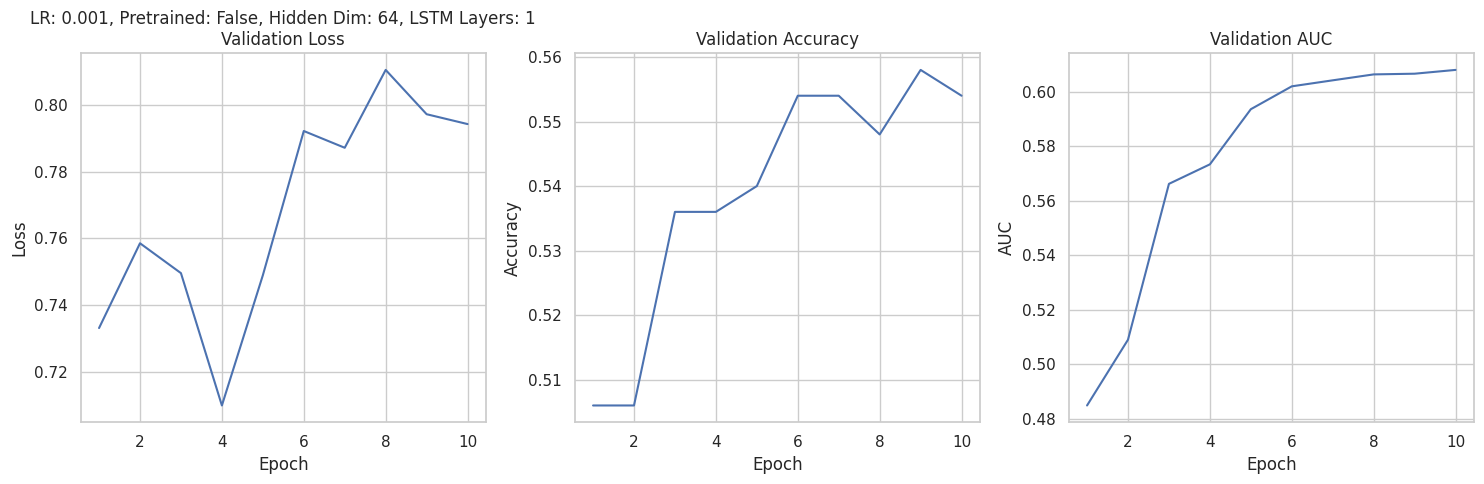

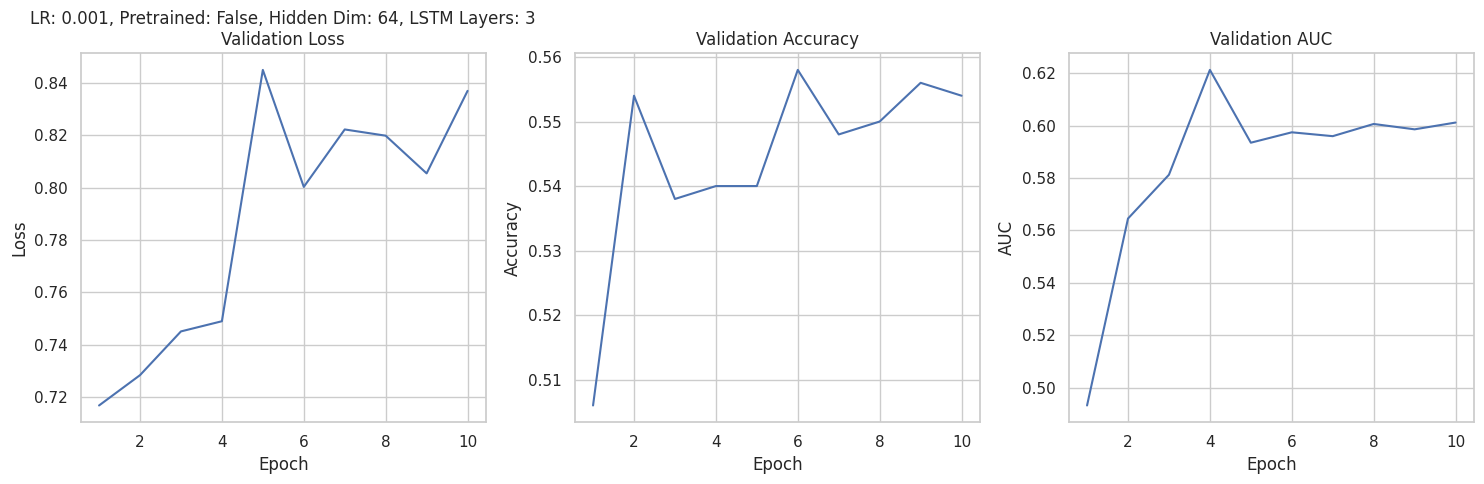

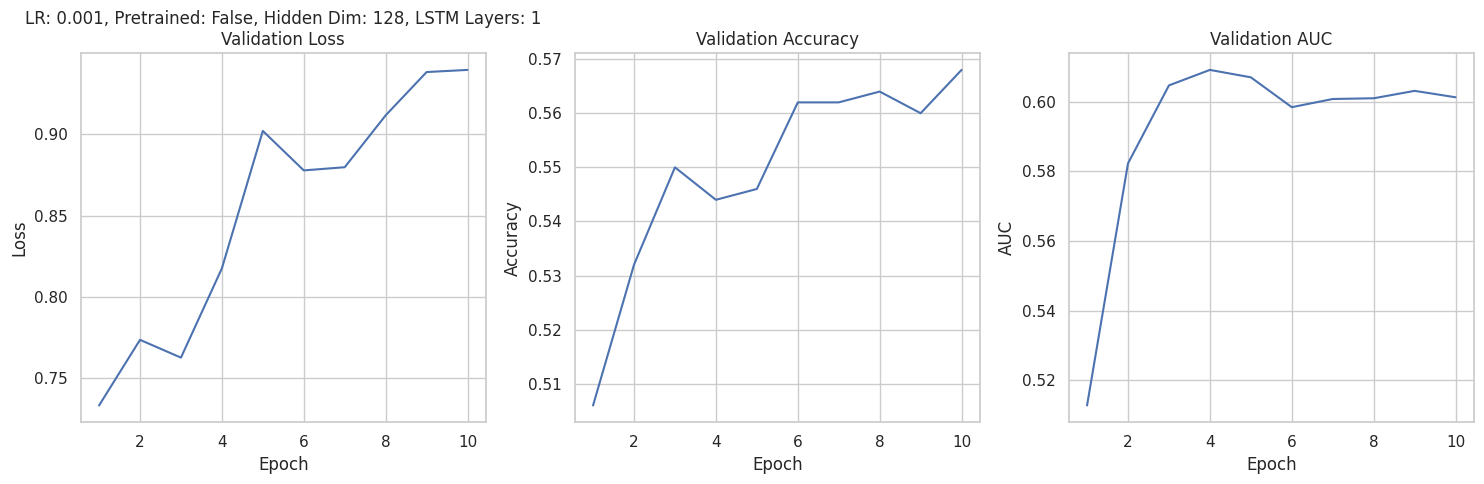

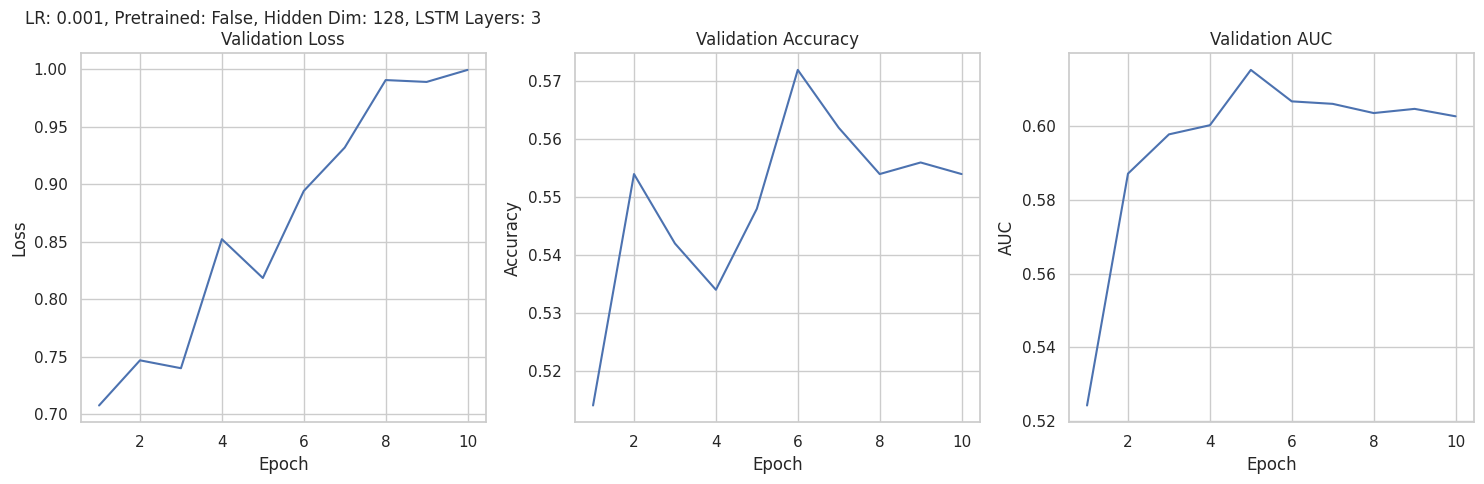

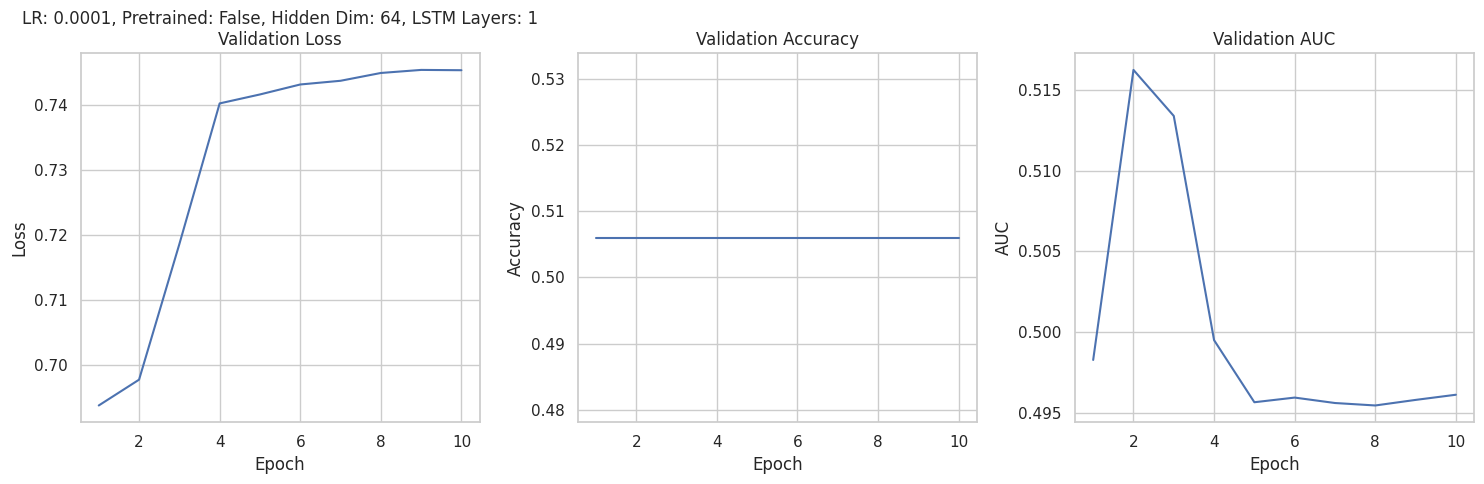

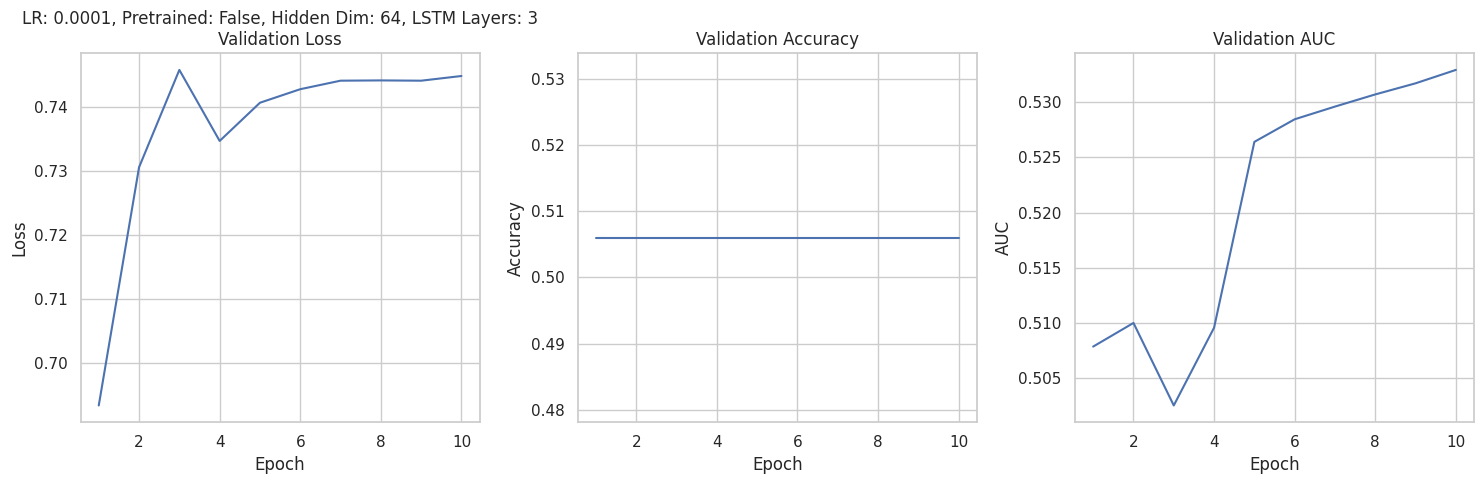

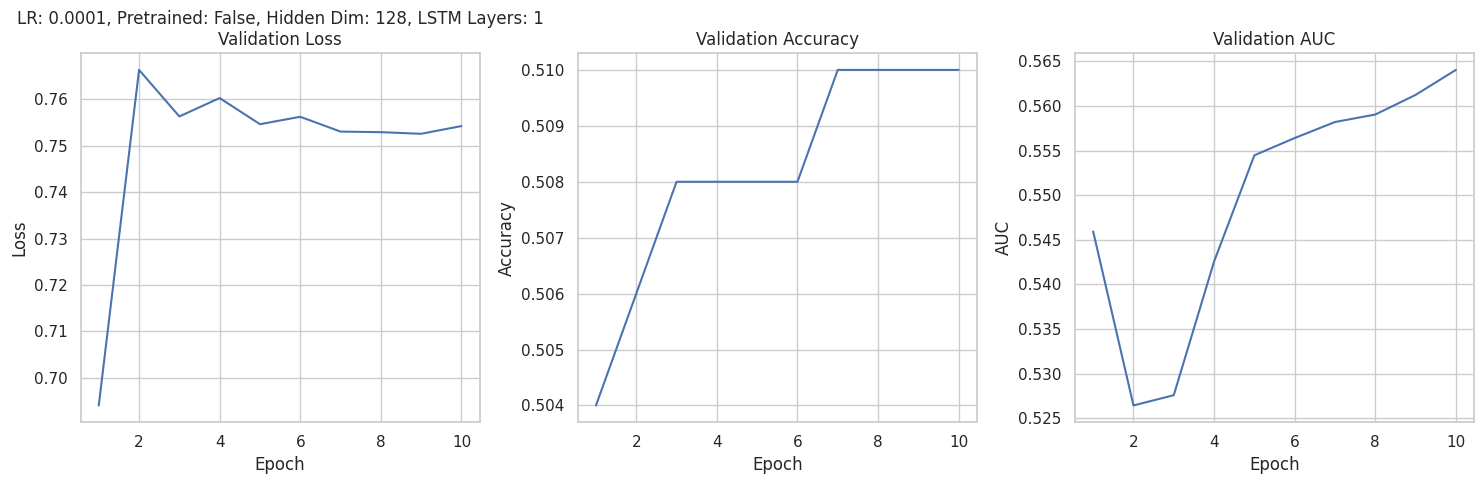

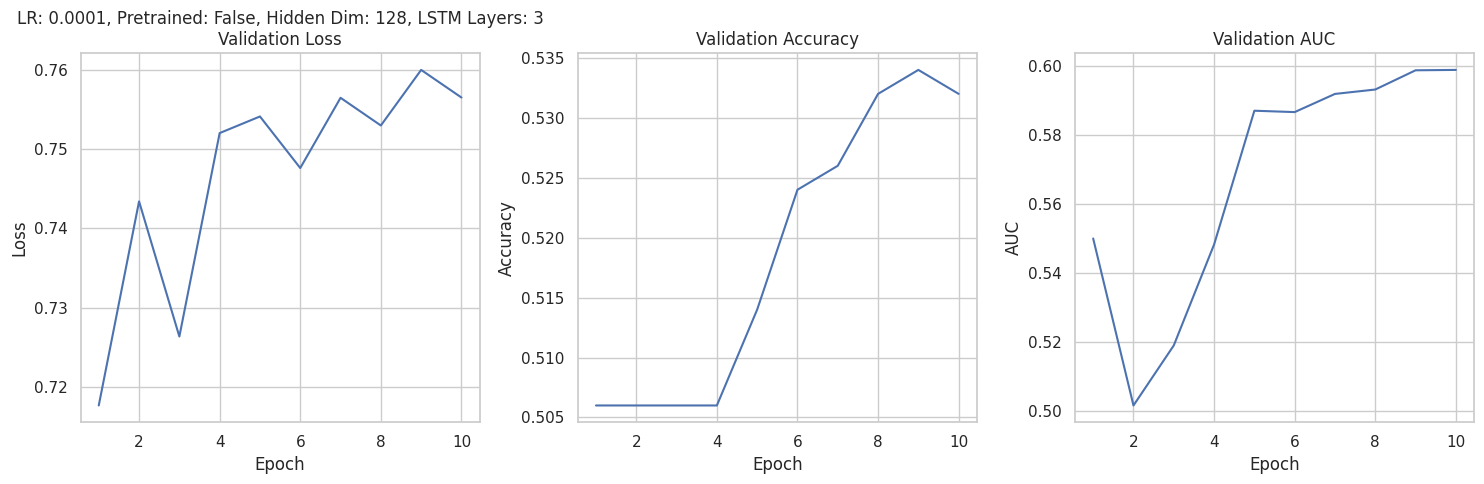

In [62]:
with open(savpath, "rb") as h:
    results = pickle.load(h)
    # write it in a file
    with open(savpath.replace(".pickle", ".tx"), "w") as file:
        data = json.dumps(results, indent=4)
        data = json.loads(data)
        file.write(json.dumps(results, indent=4))

# Convert the data to a DataFrame for easier manipulation
df_list = []
for entry in data:
    for metric in ['val_loss', 'val_acc', 'val_auc']:
        for i, value in enumerate(entry[metric]):
            df_list.append({
                'lr': entry['lr'],
                'pretrained': entry['pretrained'],
                'hidden_dim': entry['hidden_dim'],
                "lstm_layers": entry['lstm_layers'],
                'metric': metric,
                'epoch': i+1,
                'value': value
            })

df = pd.DataFrame(df_list)

# Plotting
sns.set(style="whitegrid")

# Iterate over all combinations and create a plot for each
for lr in learning_rates:
    for pretrained_ in pretrained:
        for hidden_dim in hidden_dims:
            for lstm_layers_ in lstm_layers:
                if pretrained_ is True:
                    continue
                # Filter data for the current combination
                df_filtered = df[(df['lr'] == lr) & (df['pretrained'] == pretrained_) & 
                                 (df['hidden_dim'] == hidden_dim) & (df['lstm_layers'] == lstm_layers_)]

                plt.figure(figsize=(15, 5))

                # Loss plot
                plt.subplot(1, 3, 1)
                sns.lineplot(data=df_filtered[df_filtered['metric'] == 'val_loss'], x='epoch', y='value')
                plt.title(f'LR: {lr}, Pretrained: {pretrained_}, Hidden Dim: {hidden_dim}, LSTM Layers: {lstm_layers_}\nValidation Loss')
                plt.ylabel('Loss')
                plt.xlabel('Epoch')

                # Accuracy plot
                plt.subplot(1, 3, 2)
                sns.lineplot(data=df_filtered[df_filtered['metric'] == 'val_acc'], x='epoch', y='value')
                plt.title('Validation Accuracy')
                plt.ylabel('Accuracy')
                plt.xlabel('Epoch')

                # AUC plot
                plt.subplot(1, 3, 3)
                sns.lineplot(data=df_filtered[df_filtered['metric'] == 'val_auc'], x='epoch', y='value')
                plt.title('Validation AUC')
                plt.ylabel('AUC')
                plt.xlabel('Epoch')

                plt.tight_layout()
                plt.savefig(f'results/baseline_fbhm_text_lr_{lr}_pt_{pretrained_}_hd_{hidden_dim}_l_{lstm_layers_}.png')
                plt.show()



In [13]:
savpath = "results/baselines_fbhm_image.pickle"
ckpt = f"ckpt/baseline_fbhm_image.pt"
max_auc = 0
for learning_rate in learning_rates:
    for pretrained_ in pretrained:
        for hidden_dim in hidden_dims:
            print(f"lr={learning_rate} - pt={pretrained_} - hd={hidden_dim}")

            model = ImageOnly(
                pretrained=pretrained_,
                hidden_dim=hidden_dim,
                num_classes=1,
                device=device,
            ).to(device)
            criterion = torch.nn.BCEWithLogitsLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

            start = time.time()
            val_loss = []
            val_acc = []
            val_auc = []
            for epoch in range(epochs):
                model.train()
                for data in train_dl:
                    labels = data["label"].to(device)
                    optimizer.zero_grad()
                    outputs = model(data)
                    loss_ = criterion(outputs, labels.float().view(-1, 1))
                    loss_.backward()
                    optimizer.step()

                model.eval()
                val_loss_ = 0
                y_score = []
                y_true = []
                y_pred = []
                with torch.no_grad():
                    for data in val_dl:
                        labels = data["label"].to(device)
                        outputs = model(data)
                        val_loss_ += criterion(
                            outputs, labels.float().view(-1, 1)
                        ).item()
                        score = torch.sigmoid(outputs.data)
                        y_score.extend(score.cpu().numpy().tolist())
                        y_true.extend(labels.cpu().numpy().tolist())
                        y_pred.extend((score > 0.5).cpu().numpy().tolist())

                val_loss_ /= len(val_dl)
                val_acc_ = accuracy_score(y_true, y_pred)
                val_auc_ = roc_auc_score(y_true, y_score)

                if val_auc_ > max_auc:
                    max_auc = val_auc_
                    torch.save(model, ckpt)
                    with open(f"{ckpt[:-3]}.txt", "w") as file:
                        file.write(
                            json.dumps(
                                {
                                    "lr": learning_rate,
                                    "pretrained": pretrained_,
                                    "hidden_dim": hidden_dim,
                                    "val_loss": val_loss_,
                                    "val_acc": val_acc_,
                                    "val_auc": val_auc_,
                                    "epoch": epoch,
                                }
                            )
                        )

                val_loss.append(val_loss_)
                val_acc.append(val_acc_)
                val_auc.append(val_auc_)

                print(
                    f"Epoch {epoch+1}/{epochs} - loss: {val_loss_:.4f} - acc: {val_acc_:.4f} - auc: {val_auc_:.4f}"
                )

                if epoch == int(epochs / 2) - 1:
                    for g in optimizer.param_groups:
                        g["lr"] = learning_rate / 10

            result = {
                "lr": learning_rate,
                "pretrained": pretrained_,
                "hidden_dim": hidden_dim,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_auc": val_auc,
                "time": time.time() - start,
            }
            print(json.dumps(result, indent=4))
            results.append(result)

            with open(savpath, "wb") as h:
                pickle.dump(results, h, protocol=pickle.HIGHEST_PROTOCOL)

lr=0.001 - pt=True - hd=64


/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - loss: 0.7272 - acc: 0.4960 - auc: 0.4826
Epoch 2/10 - loss: 0.7269 - acc: 0.5000 - auc: 0.4955
Epoch 3/10 - loss: 0.7466 - acc: 0.5000 - auc: 0.5366
Epoch 4/10 - loss: 0.7736 - acc: 0.5180 - auc: 0.5375
Epoch 5/10 - loss: 0.7383 - acc: 0.5040 - auc: 0.5361
Epoch 6/10 - loss: 0.7386 - acc: 0.5140 - auc: 0.4989
Epoch 7/10 - loss: 0.7347 - acc: 0.5340 - auc: 0.5187
Epoch 8/10 - loss: 0.7723 - acc: 0.5060 - auc: 0.5491
Epoch 9/10 - loss: 0.7587 - acc: 0.5100 - auc: 0.5420
Epoch 10/10 - loss: 0.7873 - acc: 0.5100 - auc: 0.5572
{
    "lr": 0.001,
    "pretrained": true,
    "hidden_dim": 64,
    "val_loss": [
        0.7271684408187866,
        0.7269428670406342,
        0.746630921959877,
        0.773591011762619,
        0.738256573677063,
        0.7385648936033249,
        0.7346894890069962,
        0.7723134756088257,
        0.7586929351091385,
        0.7873023301362991
    ],
    "val_acc": [
        0.496,
        0.5,
        0.5,
        0.518,
        0.504,
     

/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - loss: 0.7243 - acc: 0.4820 - auc: 0.4765
Epoch 2/10 - loss: 0.7627 - acc: 0.5000 - auc: 0.4861
Epoch 3/10 - loss: 0.7624 - acc: 0.5100 - auc: 0.5134
Epoch 4/10 - loss: 0.7508 - acc: 0.5240 - auc: 0.5205
Epoch 5/10 - loss: 0.7166 - acc: 0.4980 - auc: 0.4631
Epoch 6/10 - loss: 0.7407 - acc: 0.4960 - auc: 0.5032
Epoch 7/10 - loss: 0.7494 - acc: 0.5000 - auc: 0.5241
Epoch 8/10 - loss: 0.7648 - acc: 0.5060 - auc: 0.5403
Epoch 9/10 - loss: 0.7745 - acc: 0.5140 - auc: 0.5330
Epoch 10/10 - loss: 0.7550 - acc: 0.5260 - auc: 0.5342
{
    "lr": 0.001,
    "pretrained": true,
    "hidden_dim": 128,
    "val_loss": [
        0.7242733240127563,
        0.7626783102750778,
        0.7624099999666214,
        0.7507999837398529,
        0.7166364043951035,
        0.7406524419784546,
        0.7494333237409592,
        0.7647556066513062,
        0.7744825780391693,
        0.7550089508295059
    ],
    "val_acc": [
        0.482,
        0.5,
        0.51,
        0.524,
        0.498,


/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10 - loss: 0.7596 - acc: 0.5060 - auc: 0.4929
Epoch 2/10 - loss: 0.7294 - acc: 0.4860 - auc: 0.4587
Epoch 3/10 - loss: 0.7467 - acc: 0.5080 - auc: 0.5143
Epoch 4/10 - loss: 0.7326 - acc: 0.5060 - auc: 0.4905
Epoch 5/10 - loss: 0.7209 - acc: 0.5060 - auc: 0.4982
Epoch 6/10 - loss: 0.7387 - acc: 0.5060 - auc: 0.4947
Epoch 7/10 - loss: 0.7403 - acc: 0.5060 - auc: 0.4879
Epoch 8/10 - loss: 0.7371 - acc: 0.5060 - auc: 0.4848
Epoch 9/10 - loss: 0.7383 - acc: 0.5100 - auc: 0.4834
Epoch 10/10 - loss: 0.7420 - acc: 0.5060 - auc: 0.4880
{
    "lr": 0.001,
    "pretrained": false,
    "hidden_dim": 64,
    "val_loss": [
        0.7595591694116592,
        0.7294449359178543,
        0.7467173039913177,
        0.7326313853263855,
        0.7209459990262985,
        0.7386906445026398,
        0.7402859628200531,
        0.7371023148298264,
        0.7383010238409042,
        0.7419623136520386
    ],
    "val_acc": [
        0.506,
        0.486,
        0.508,
        0.506,
        0.50

/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10 - loss: 0.7186 - acc: 0.4940 - auc: 0.5246
Epoch 2/10 - loss: 0.8175 - acc: 0.5060 - auc: 0.5041
Epoch 3/10 - loss: 0.7171 - acc: 0.4740 - auc: 0.4606
Epoch 4/10 - loss: 0.7340 - acc: 0.5060 - auc: 0.5033
Epoch 5/10 - loss: 0.7342 - acc: 0.4980 - auc: 0.4782
Epoch 6/10 - loss: 0.7393 - acc: 0.5080 - auc: 0.4854
Epoch 7/10 - loss: 0.7477 - acc: 0.5060 - auc: 0.4946
Epoch 8/10 - loss: 0.7470 - acc: 0.5120 - auc: 0.4931
Epoch 9/10 - loss: 0.7327 - acc: 0.5100 - auc: 0.5025
Epoch 10/10 - loss: 0.7379 - acc: 0.5120 - auc: 0.4944
{
    "lr": 0.001,
    "pretrained": false,
    "hidden_dim": 128,
    "val_loss": [
        0.7186231464147568,
        0.8175458908081055,
        0.7170574814081192,
        0.734041765332222,
        0.7341582775115967,
        0.739265188574791,
        0.747661367058754,
        0.7469667196273804,
        0.7326508015394211,
        0.7379392832517624
    ],
    "val_acc": [
        0.494,
        0.506,
        0.474,
        0.506,
        0.498,

/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - loss: 0.7905 - acc: 0.5020 - auc: 0.5275
Epoch 2/10 - loss: 0.8306 - acc: 0.5020 - auc: 0.5080
Epoch 3/10 - loss: 0.8414 - acc: 0.5040 - auc: 0.5062
Epoch 4/10 - loss: 0.9671 - acc: 0.5000 - auc: 0.4975
Epoch 5/10 - loss: 0.9669 - acc: 0.4900 - auc: 0.4729
Epoch 6/10 - loss: 1.0736 - acc: 0.5160 - auc: 0.4931
Epoch 7/10 - loss: 1.1086 - acc: 0.5120 - auc: 0.4900
Epoch 8/10 - loss: 1.1430 - acc: 0.5140 - auc: 0.4916
Epoch 9/10 - loss: 1.1807 - acc: 0.5040 - auc: 0.4894
Epoch 10/10 - loss: 1.2437 - acc: 0.5200 - auc: 0.4906
{
    "lr": 0.0001,
    "pretrained": true,
    "hidden_dim": 64,
    "val_loss": [
        0.7905034571886063,
        0.8306155204772949,
        0.8414445072412491,
        0.9671220779418945,
        0.9668577462434769,
        1.0735752284526825,
        1.1085989624261856,
        1.1429566442966461,
        1.180732622742653,
        1.243727907538414
    ],
    "val_acc": [
        0.502,
        0.502,
        0.504,
        0.5,
        0.49,
  

/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - loss: 0.7199 - acc: 0.5040 - auc: 0.5299
Epoch 2/10 - loss: 0.7410 - acc: 0.5140 - auc: 0.5370
Epoch 3/10 - loss: 0.8427 - acc: 0.4980 - auc: 0.5033
Epoch 4/10 - loss: 1.0314 - acc: 0.5140 - auc: 0.5118
Epoch 5/10 - loss: 1.0078 - acc: 0.5180 - auc: 0.5162
Epoch 6/10 - loss: 1.0204 - acc: 0.5100 - auc: 0.5128
Epoch 7/10 - loss: 1.0612 - acc: 0.4920 - auc: 0.5141
Epoch 8/10 - loss: 1.1011 - acc: 0.4940 - auc: 0.5047
Epoch 9/10 - loss: 1.1640 - acc: 0.4920 - auc: 0.5037
Epoch 10/10 - loss: 1.1975 - acc: 0.4820 - auc: 0.5004
{
    "lr": 0.0001,
    "pretrained": true,
    "hidden_dim": 128,
    "val_loss": [
        0.719886988401413,
        0.7409513145685196,
        0.8426614254713058,
        1.0313846915960312,
        1.0077651590108871,
        1.020446553826332,
        1.0612152069807053,
        1.1011186987161636,
        1.1639587581157684,
        1.1975497752428055
    ],
    "val_acc": [
        0.504,
        0.514,
        0.498,
        0.514,
        0.518

/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10 - loss: 0.7273 - acc: 0.5060 - auc: 0.4924
Epoch 2/10 - loss: 0.7729 - acc: 0.5060 - auc: 0.5414
Epoch 3/10 - loss: 0.7407 - acc: 0.5060 - auc: 0.5122
Epoch 4/10 - loss: 0.7519 - acc: 0.5000 - auc: 0.4749
Epoch 5/10 - loss: 0.7243 - acc: 0.5220 - auc: 0.5351
Epoch 6/10 - loss: 0.7416 - acc: 0.5220 - auc: 0.5423
Epoch 7/10 - loss: 0.7201 - acc: 0.5280 - auc: 0.5462
Epoch 8/10 - loss: 0.7170 - acc: 0.5260 - auc: 0.5458
Epoch 9/10 - loss: 0.7304 - acc: 0.5160 - auc: 0.5408
Epoch 10/10 - loss: 0.7366 - acc: 0.5140 - auc: 0.5522
{
    "lr": 0.0001,
    "pretrained": false,
    "hidden_dim": 64,
    "val_loss": [
        0.7272960990667343,
        0.772858664393425,
        0.7406888008117676,
        0.7519345283508301,
        0.7243007719516754,
        0.7415892630815506,
        0.7201065272092819,
        0.717027559876442,
        0.7304172217845917,
        0.7366296201944351
    ],
    "val_acc": [
        0.506,
        0.506,
        0.506,
        0.5,
        0.522,


/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10 - loss: 0.7608 - acc: 0.5080 - auc: 0.4918
Epoch 2/10 - loss: 0.7542 - acc: 0.5060 - auc: 0.4745
Epoch 3/10 - loss: 0.7198 - acc: 0.4760 - auc: 0.4774
Epoch 4/10 - loss: 0.7075 - acc: 0.5100 - auc: 0.5116
Epoch 5/10 - loss: 0.7597 - acc: 0.5020 - auc: 0.5110
Epoch 6/10 - loss: 0.7309 - acc: 0.5080 - auc: 0.5045
Epoch 7/10 - loss: 0.7368 - acc: 0.5160 - auc: 0.5109
Epoch 8/10 - loss: 0.7481 - acc: 0.5080 - auc: 0.5213
Epoch 9/10 - loss: 0.7253 - acc: 0.5260 - auc: 0.5223
Epoch 10/10 - loss: 0.7500 - acc: 0.5180 - auc: 0.5169
{
    "lr": 0.0001,
    "pretrained": false,
    "hidden_dim": 128,
    "val_loss": [
        0.7608062624931335,
        0.7542377263307571,
        0.7197656780481339,
        0.7074567675590515,
        0.7596682906150818,
        0.7309281677007675,
        0.736754760146141,
        0.7481351345777512,
        0.7253443896770477,
        0.7499707341194153
    ],
    "val_acc": [
        0.508,
        0.506,
        0.476,
        0.51,
        0.50

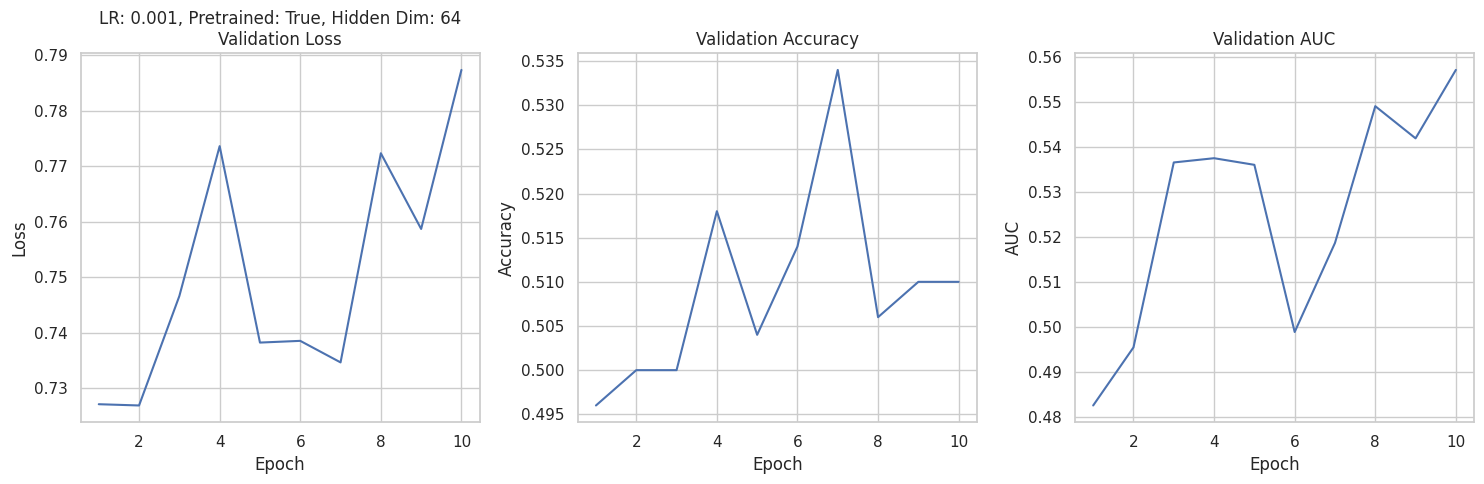

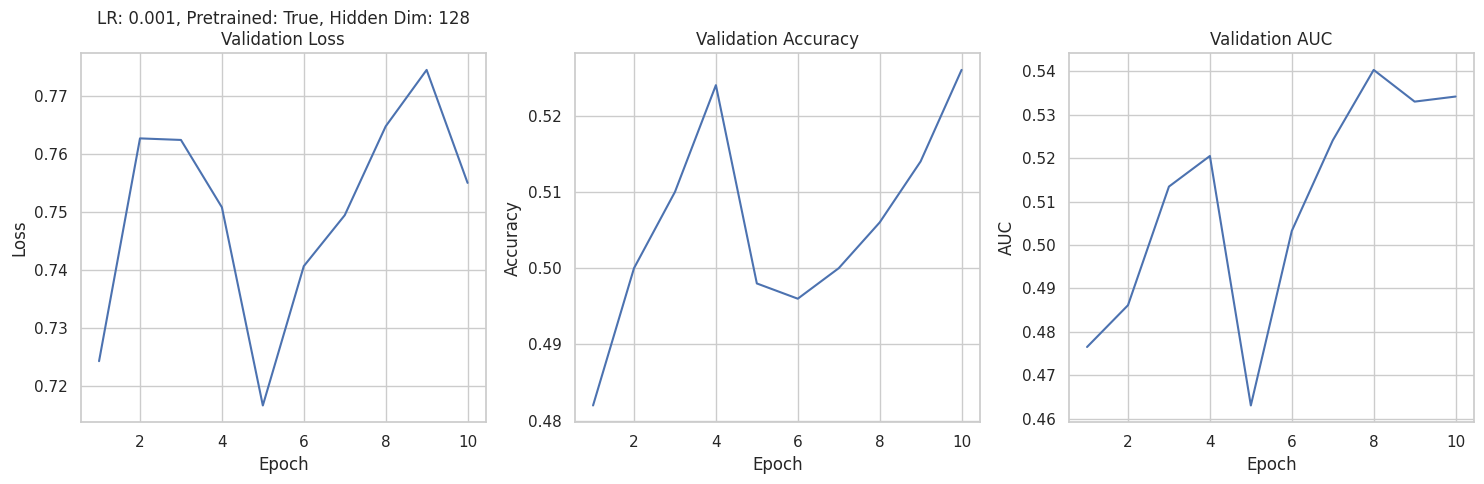

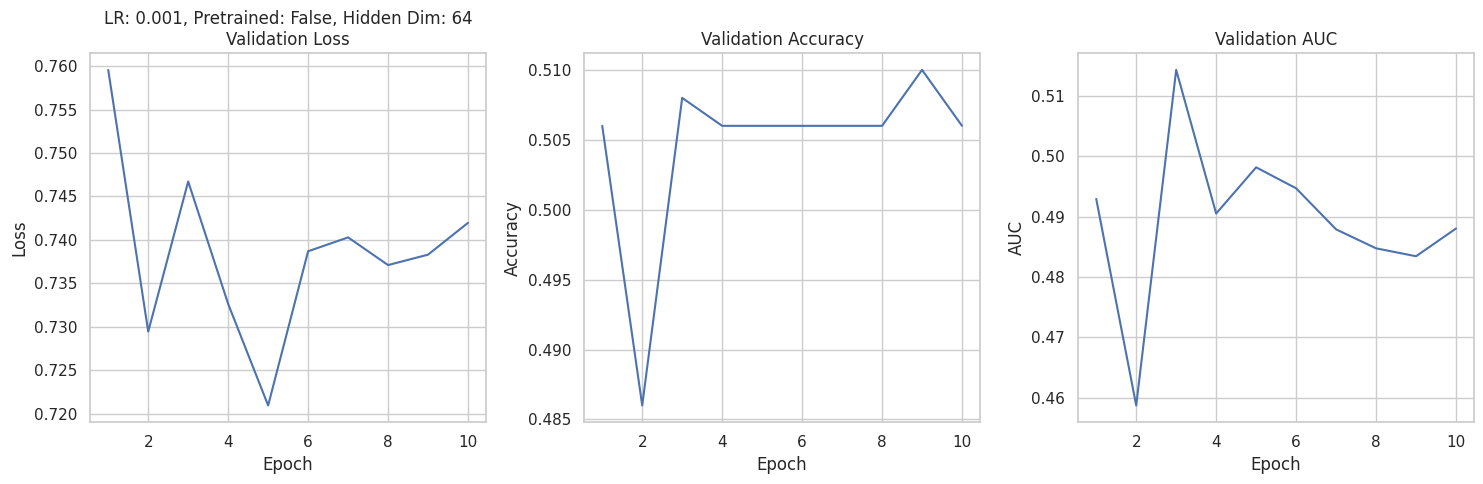

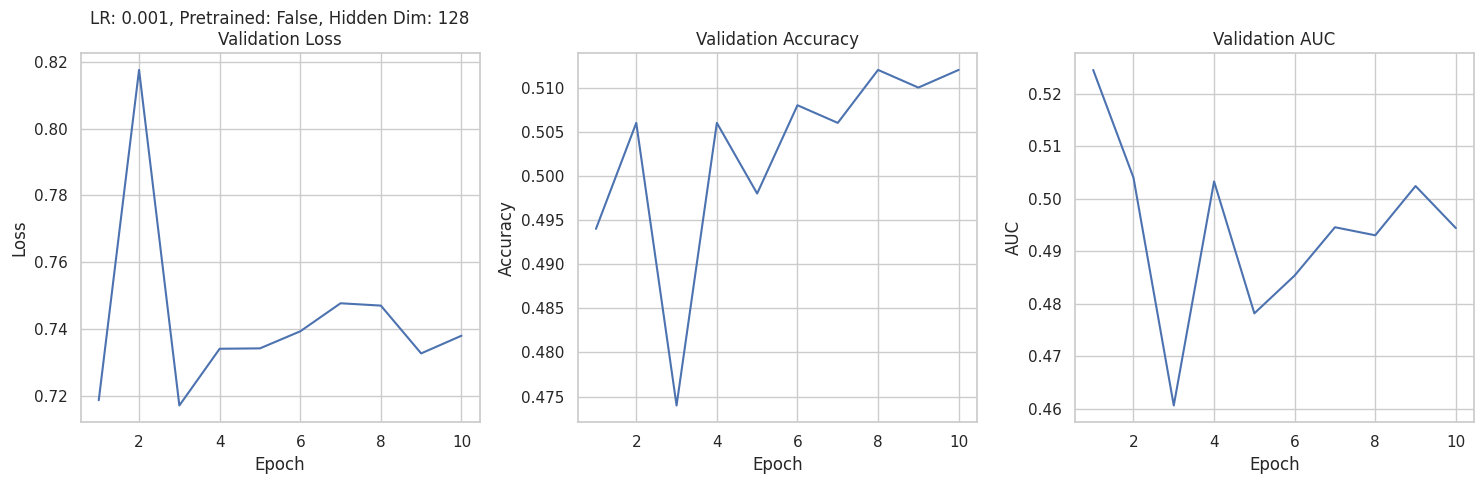

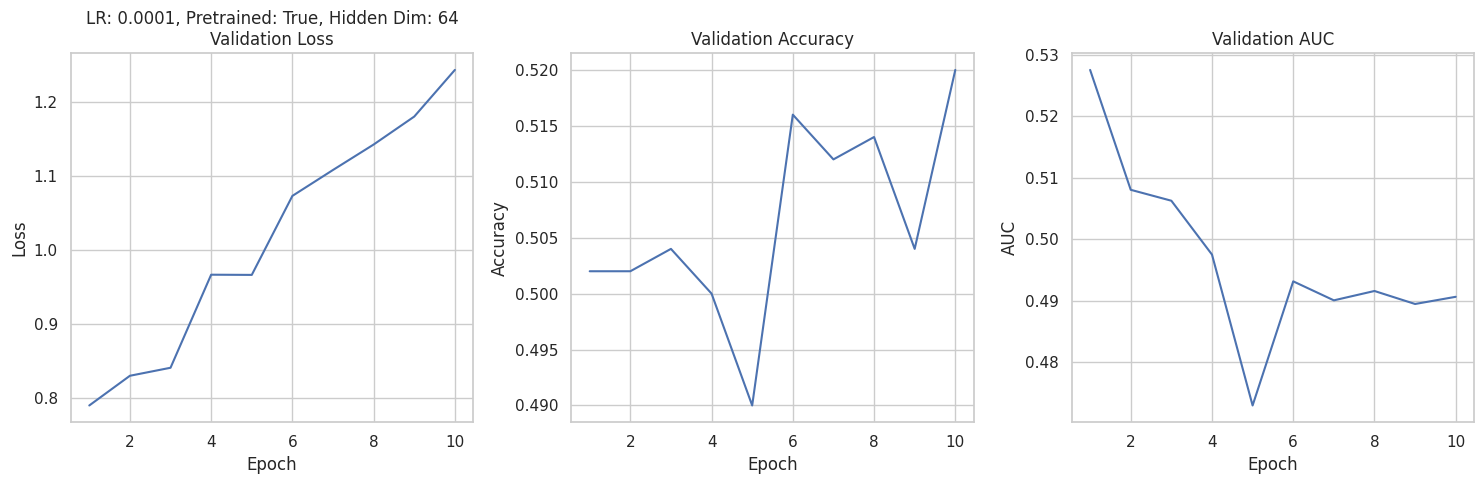

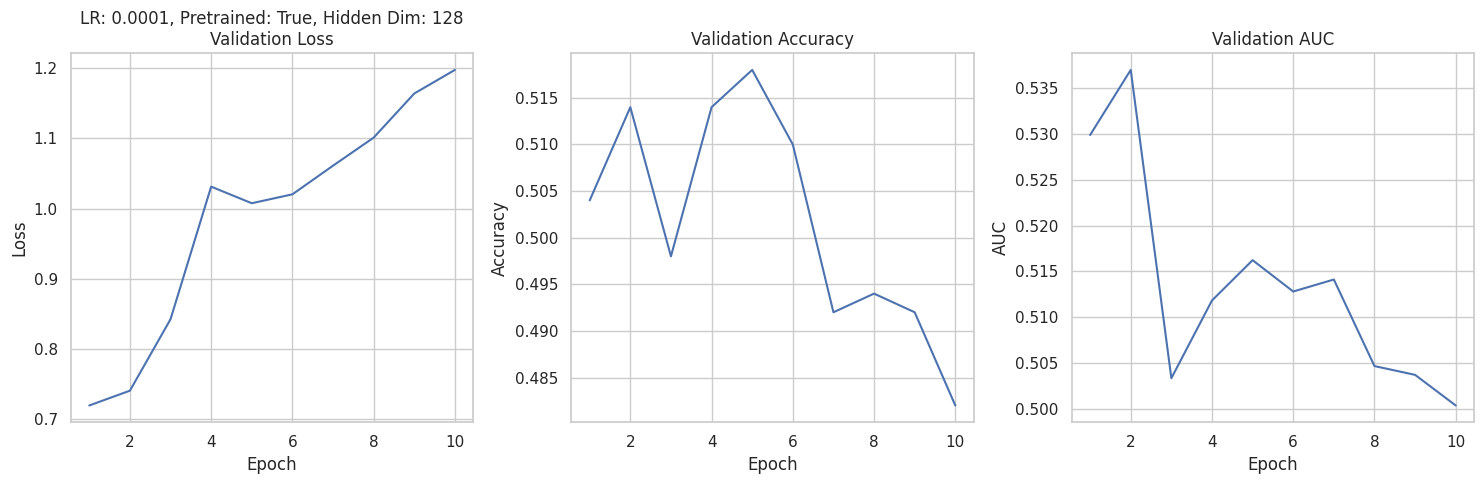

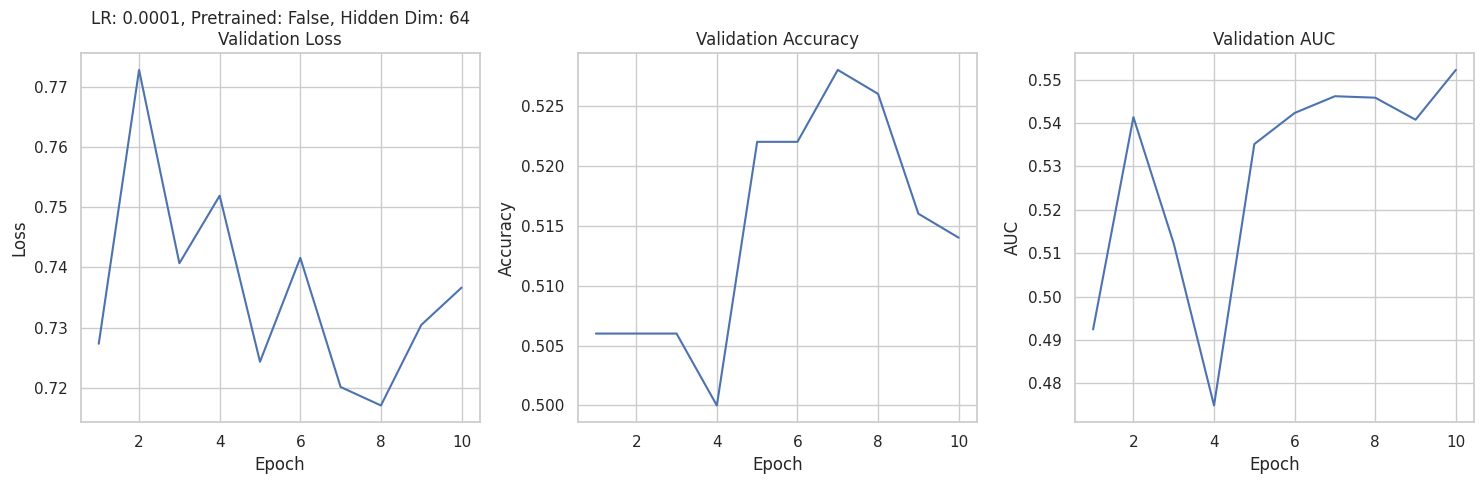

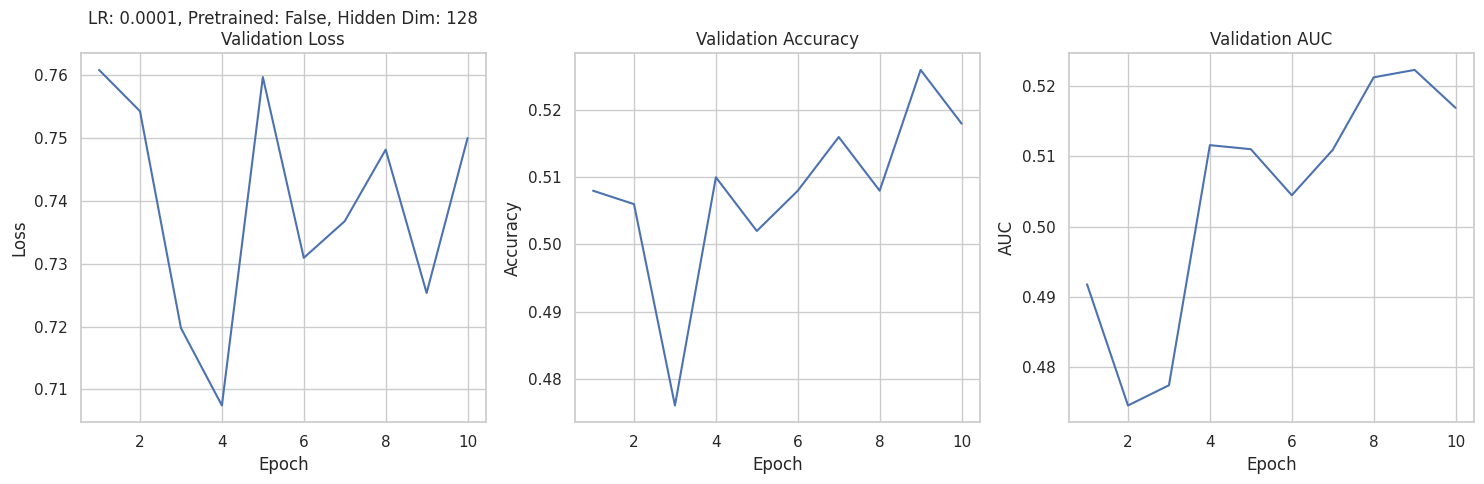

In [14]:
with open(savpath, "rb") as h:
    results = pickle.load(h)
    # write it in a file
    with open(savpath.replace(".pickle", ".tx"), "w") as file:
        data = json.dumps(results, indent=4)
        data = json.loads(data)
        file.write(json.dumps(results, indent=4))

# Convert the data to a DataFrame for easier manipulation
df_list = []
for entry in data:
    for metric in ['val_loss', 'val_acc', 'val_auc']:
        for i, value in enumerate(entry[metric]):
            df_list.append({
                'lr': entry['lr'],
                'pretrained': entry['pretrained'],
                'hidden_dim': entry['hidden_dim'],
                'metric': metric,
                'epoch': i+1,
                'value': value
            })

df = pd.DataFrame(df_list)

# Plotting
sns.set(style="whitegrid")

# Iterate over all combinations and create a plot for each
for lr in learning_rates:
    for pretrained_ in pretrained:
        for hidden_dim in hidden_dims:
                # Filter data for the current combination
                df_filtered = df[(df['lr'] == lr) & (df['pretrained'] == pretrained_) & 
                                 (df['hidden_dim'] == hidden_dim)]

                plt.figure(figsize=(15, 5))

                # Loss plot
                plt.subplot(1, 3, 1)
                sns.lineplot(data=df_filtered[df_filtered['metric'] == 'val_loss'], x='epoch', y='value')
                plt.title(f'LR: {lr}, Pretrained: {pretrained_}, Hidden Dim: {hidden_dim}\nValidation Loss')
                plt.ylabel('Loss')
                plt.xlabel('Epoch')

                # Accuracy plot
                plt.subplot(1, 3, 2)
                sns.lineplot(data=df_filtered[df_filtered['metric'] == 'val_acc'], x='epoch', y='value')
                plt.title('Validation Accuracy')
                plt.ylabel('Accuracy')
                plt.xlabel('Epoch')

                # AUC plot
                plt.subplot(1, 3, 3)
                sns.lineplot(data=df_filtered[df_filtered['metric'] == 'val_auc'], x='epoch', y='value')
                plt.title('Validation AUC')
                plt.ylabel('AUC')
                plt.xlabel('Epoch')

                plt.tight_layout()
                plt.savefig(f'results/baseline_fbhm_image_lr_{lr}_pt_{pretrained_}_hd_{hidden_dim}.png')
                plt.show()

